In [1]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import logging

from sklearn.metrics import top_k_accuracy_score, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
import torch
from pytorch_lightning import Trainer
from torch_geometric.data import DataLoader

In [2]:
import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from model.model import SingleFramework
from model.hetero_data import DataObject
from utils import load_graph_information

In [3]:
torch.set_default_dtype(torch.float64)
logging.getLogger().setLevel(logging.INFO)

In [4]:
matplotlib.style.use("seaborn")

# Inference on pre-trained model

In [5]:
# Define seed.
SEED = 3
# Dataset name.
DATASET_TARGET = "real-world/Dribbble"

## Load dataset

In [6]:
dataset_path = f"../../../datasets/{DATASET_TARGET}/data"

In [7]:
graph, teams_composition, teams_label, nodes_attribute, teams_members, nodes_name, teams_name = load_graph_information(dataset_path)

INFO:root:Directed graph: True
INFO:root:Number of nodes: 5196
INFO:root:Number of edges: 304315
INFO:root:Number of teams: 769
INFO:root:Number of classes: 3
INFO:root:Number of features for each node: 6
INFO:root:Number of nodes that not belong to any team: 0
INFO:root:Overlapping members of the teams: True


In [8]:
# Define the teams and the team labels.
df_labels = pd.DataFrame(teams_label.items(), columns = ["team", "label"])
df_labels.head()

,team,label
0,0,2
1,1,2
2,2,0
3,3,0
4,4,1


In [9]:
teams = df_labels["team"].tolist()
n_teams = len(teams)
n_classes = df_labels["label"].nunique()

In [10]:
class_distribution = df_labels["label"].value_counts(normalize = True)
class_distribution

label
1    0.449935
0    0.331599
2    0.218466
Name: proportion, dtype: float64

In [11]:
# Get nodes that not belong to the teams: 'None' value in correspondence of no team belonging.
nodes_not_belong_to_teams = [node for node, teams in teams_composition.items() if teams is None]

## Load best parameters obtained from previous training and validation phases

In [12]:
# Load best hyperparameters of the current analysis.
with open(f"../results/3-channels/{DATASET_TARGET}/best_params/{SEED}.pkl", "rb") as f:
    best_params = pickle.load(f)  

In [13]:
best_params

{'flow_conv_t': 'source_to_target',
 'flow_conv_c': 'source_to_target',
 'agg_conv_t': 'sum',
 'agg_conv_c': 'sum',
 'agg_conv_p': 'sum',
 'agg_team_t': 'mean',
 'hidden_dim': 16,
 'dropout_t': 0.75,
 'dropout_c': 0.35000000000000003,
 'dropout_a': 0.7,
 'epochs': 42.0,
 'lr_base': 0.05949621962730532,
 'lr_swa': 0.020733343704054205,
 'swa_start': 0.65,
 'swa_freq': 3,
 'norm_func': 'QuantileTransformer'}

## Preprocessing input - Channels

In [14]:
# Load subgraphs in isolation.
HeteroData = DataObject(graph, teams_composition, teams_members, teams_label, nodes_not_belong_to_teams, nodes_attribute, nodes_name)
HeteroData.get_subgraphs()

# Load data object.
data = torch.load(f"../results/3-channels/{DATASET_TARGET}/data_objects/{SEED}")
data

HeteroData(
  n_teams=769,
  y=[769],
  n_classes=3,
  train_teams=[615],
  train_labels=[615],
  mask_train=[769],
  mask_test=[769],
  topology={
    x=[5454, 6],
    edge_index=[2, 26895],
    composition=[5454],
    norm=True,
    x_norm=[5454, 6]
  },
  centrality={
    x=[769, 1],
    edge_index=[2, 119085],
    edge_weight=[119085, 1],
    mask_teams=[769]
  },
  position={
    x=[769, 1],
    dists_max=[769, 81],
    dists_argmax=[769, 81],
    n_anchorsets=81,
    mask_teams=[769]
  }
)

## Model inference

In [15]:
# Initialize current model.
model = SingleFramework(input_dim_t = data["topology"].x.shape[1], input_dim_c = data["centrality"].x.shape[1], 
                        input_dim_p = data["position"].x.shape[1], n_anchorsets = data["position"].n_anchorsets, 
                        out_dim = data.n_classes, **best_params) 

In [16]:
# Load the weights previous trained.
def weights_update(model, checkpoint, layers_not_to_load):
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint["state_dict"].items() if k in model_dict and k not in layers_not_to_load}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    return model

In [17]:
trained_model = weights_update(model = model, 
                               checkpoint = torch.load(f"../results/3-channels/{DATASET_TARGET}/model_weights/{SEED}.ckpt"), 
                               layers_not_to_load = []) 

train_loader = DataLoader([data], batch_size = 1, shuffle = False)
trainer = Trainer(gpus = 1, checkpoint_callback = False, logger = False) 
result = trainer.test(trained_model, test_dataloaders = train_loader)    
test_acc = result[0]["test_acc"]
test_f1 = result[0]["test_f1"]
test_auroc = result[0]["test_auroc"]

C:\Users\Pietro\Desktop\Mentor\venv\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\Pietro\Desktop\Mentor\venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:899: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.7077922224998474,
 'test_auroc': 0.8771277070045471,
 'test_f1': 0.7077922224998474}
--------------------------------------------------------------------------------


## Analysis

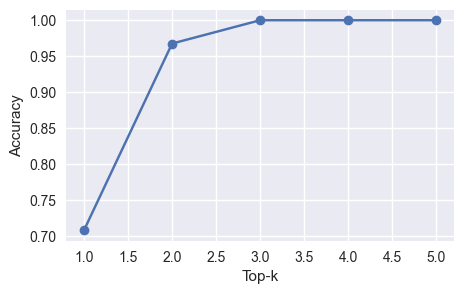

In [18]:
# Compute top-k accuracy.
y_prob, y_true = model.test_predictions
test_top_n_acc = [top_k_accuracy_score(y_true, y_prob, k = i+1) for i in range(5)]

fig, axs = plt.subplots(figsize = (5, 3))
axs.plot(np.arange(5)+1, test_top_n_acc, "-o")
axs.set_ylabel("Accuracy")
axs.set_xlabel("Top-k");

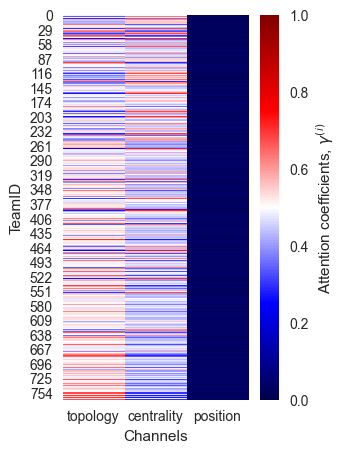

In [19]:
# Plot channel attentions.
att_prob = model.attentions_channels.detach().cpu().numpy()
df = pd.DataFrame(att_prob, columns = model.channels)

fig, axs = plt.subplots(figsize = (3, 5), ncols = 1, nrows = 1)

sns.heatmap(df, vmin = 0, vmax = 1, cmap = "seismic", cbar_kws = {"label": "Attention coefficients, $\gamma^{(i)}$"}, 
            ax = axs)

axs.set_ylabel("TeamID")
axs.set_xlabel("Channels");

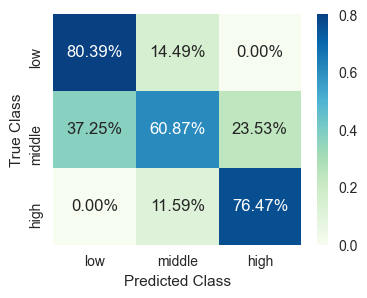

In [20]:
# Load confusion matrix.
cf_matrix = model.confusion_matrix

fig, ax = plt.subplots(figsize = (4, 3), ncols = 1, nrows = 1)

m = cf_matrix / cf_matrix.astype(np.float32).sum(axis = 1)
cax = sns.heatmap(m, annot = True, fmt = ".2%", xticklabels = ["low", "middle", "high"], yticklabels = ["low", "middle", "high"],
                  cmap = "GnBu", linewidths = 0., linecolor = "black", annot_kws = {"fontsize": 12}, 
                  ax = ax)
ax.set_ylabel("True Class")
ax.set_xlabel("Predicted Class");

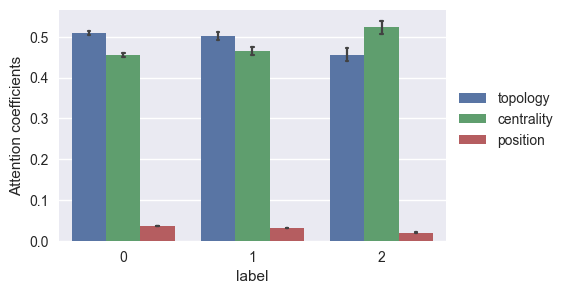

In [21]:
# Get attention coefficients in relation with label.
df = pd.DataFrame(att_prob, columns = model.channels)
df["label"] = pd.Series(teams_label)

fig, axs = plt.subplots(figsize = (5, 3), ncols = 1, nrows = 1)

m = pd.melt(df, id_vars = ["label"], value_vars = ["topology", "centrality", "position"], 
            var_name = "channels", value_name = "Attention coefficients")
sns.barplot(x = "label", hue = "channels", y = "Attention coefficients", data = m, capsize = .02, 
            estimator = np.mean, errwidth = 1.6, ci = 95)

axs.legend(loc = "best", bbox_to_anchor = (1, 0.7));

### Isolated graph (topology)

In [22]:
# Get edges topology GAT attentions.
edges = model.attentions_topology[0].detach().cpu().numpy()
att_edges = model.attentions_topology[1].detach().cpu().numpy()

In [23]:
nodes_attention_edges = []
for team_id in range(n_teams):
    # Keep nodes that belong to the current team.
    nodes = [node for node, attribute in HeteroData.isolated_graph.nodes(data = True) if attribute["Team"] == team_id]
    # Subgraph.
    subgraph = HeteroData.isolated_graph.subgraph(nodes)
    # Get the edges index position of the current team.
    mask = np.isin(edges.T, np.array(subgraph.edges())).all(axis = 1)    
    # Add weights to edges.
    weights = dict(zip(list(map(tuple, edges.T[mask])), att_edges[mask].ravel()))

    # Get attention edges.
    df = pd.DataFrame(edges.T[mask], columns = ["id1", "id2"])
    df["weights"] = att_edges[mask]
    df["team"] = team_id

    nodes_attention_edges.append(df)

In [24]:
nodes_attention = pd.concat(nodes_attention_edges, ignore_index = True)
nodes_attention.head()

,id1,id2,weights,team
0,0,4,0.217646,0
1,0,7,0.195758,0
2,0,3,0.221811,0
3,0,5,0.208270,0
4,0,2,0.211542,0


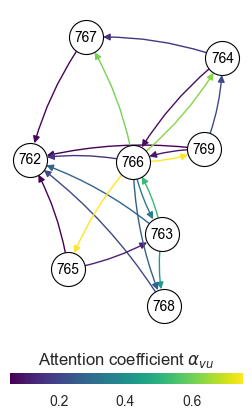

In [25]:
team_id = 89

# Keep nodes that belong to the current team.
nodes = [node for node, attribute in HeteroData.isolated_graph.nodes(data = True) if attribute["Team"] == team_id]
# Subgraph.
subgraph = HeteroData.isolated_graph.subgraph(nodes)

nodes_attention_team = nodes_attention.query("team == @team_id").set_index(["id1", "id2"])
edges = nodes_attention_team.index.tolist()
weights = nodes_attention_team["weights"].tolist()

# Get names of the nodes of the isolated subgraphs.
labels = nx.get_node_attributes(subgraph, "Name")
if labels:
    labels = {k: list(nodes_name.keys())[list(nodes_name.values()).index(v)] for k, v in labels.items()}
else:
    labels = None 

# Figure.
fig, ax = plt.subplots(figsize = (3, 5))        
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, edgelist = edges, edge_color = weights, edge_cmap = plt.cm.viridis, connectionstyle = "arc3, rad = 0.1", 
        with_labels = True, labels = labels, linewidths = 0.8, node_size = 600, node_color = "white", font_size = 10, ax = ax)

ax.collections[0].set_edgecolor("black") 

sm = plt.cm.ScalarMappable(cmap = plt.cm.viridis, norm = plt.Normalize(vmin = min(weights), vmax = max(weights)))
sm._A = []
clb = plt.colorbar(sm, orientation = "horizontal", fraction = 0.056, pad = 0.1)
clb.ax.set_title("Attention coefficient $α_{vu}$")
plt.show();

In [26]:
weight_nodes = []
for team_id in range(n_teams):
    # Keep nodes that belong to the current team.
    nodes = [node for node, attribute in HeteroData.isolated_graph.nodes(data = True) if attribute["Team"] == team_id]
    # Subgraph.
    subgraph = HeteroData.isolated_graph.subgraph(nodes)
    
    if best_params["flow_conv_t"] == "target_to_source":
        group_key = "id2"
    else:
        group_key = "id1"

    nodes_attention_team = nodes_attention.query("team == @team_id")
    df_sum = nodes_attention_team.groupby([group_key]).agg(weights = ("weights", "sum"), team = ("team", "first"))
    # Add information regarding those nodes that could not have any information (or isolated or not compatible with edge direction).
    df_sum = df_sum.reindex(subgraph.nodes())
    df_sum["team"] = df_sum["team"].fillna(team_id).astype(int)
    df_sum.set_index("team", append = True, inplace = True)
    df_sum.index.names = ["node", "team"]

    weight_nodes.append(df_sum)

In [27]:
weight_nodes = pd.concat(weight_nodes)
weight_nodes.head()

,,weights
node,team,
0,0,1.402239
1,0,1.514494
2,0,0.311501
3,0,1.153439
4,0,0.850325


In [28]:
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [29]:
gini_indx = weight_nodes.groupby(axis = 0, level = "team").agg(gini = ("weights", lambda x: gini_coefficient(x))) #np.abs(x-np.median(x))
gini_indx["gini"] = gini_indx["gini"].fillna(0)

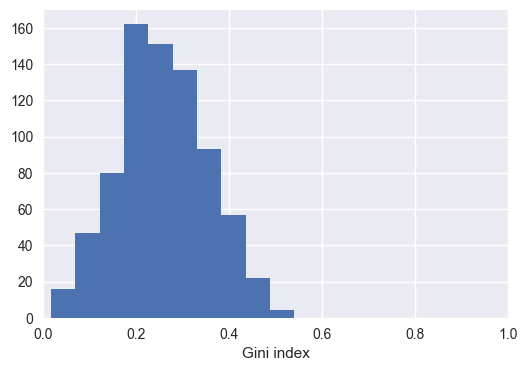

In [30]:
fig, axs = plt.subplots(figsize = (6, 4))

axs.hist(gini_indx["gini"])
axs.set_xlabel("Gini index")
axs.set_xlim([0, 1]);

In [31]:
gini_indx["gini"].idxmax()

767

In [32]:
gini_indx["gini"].idxmin()

544

In [33]:
df = nodes_attribute.xs(89, axis = 0, level = "team")

In [34]:
df = df[["n_teams_before", "n_skills", "n_comments_received_before", "n_shots_created_before", "n_likes_shot_received_before"]]

In [35]:
def invert(x, limits):
    """Inverts a value x on a scale from limits[0] to limits[1]."""
    return limits[1] - (x - limits[0])

def scale_data(data, ranges):
    """Scales data[1:] to ranges[0], inverts if the scale is reversed."""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    """Class for plotting Radar with different scales on axes."""
    def __init__(self, fig, variables, ranges, n_ordinate_levels=5):
        angles = np.arange(0, 360, 360./len(variables))
        axes = [fig.add_axes([0.1,0.1,0.9,0.9], projection="polar", label = "axes{}".format(i)) for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, labels = variables, fontsize = 9, alpha = 0.5, color = "black")
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
            ax.yaxis.grid(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], num = n_ordinate_levels)
            gridlabel = ["{}".format(int(x)) for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels = gridlabel, angle = angles[i], fontsize = 9, alpha = 0.5, color = "black")
            ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        
    def plot(self, data, c, label, *args, **kw):
        sdata = scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], marker = "s", markeredgecolor = "black",  
                     markersize = 6, markeredgewidth = 0.4, alpha = 0.9, linestyle = "-", 
                     color = c, *args, **kw)
        self.ax.plot([], marker = "s", markersize = 8, color = c, alpha = 0.9, linestyle = "", label = label)
        
    def fill(self, data, *args, **kw):
        sdata = scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)  

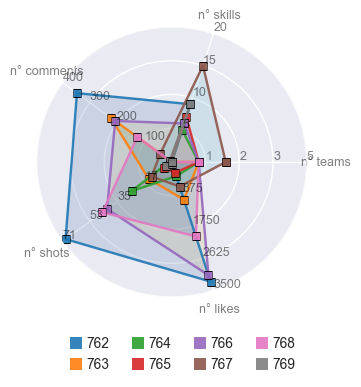

In [36]:
variables = ["n° teams", "n° skills", "n° comments", "n° shots", "n° likes"]
ranges = [(0, 5), (0, 20), (0, 400), (0, 71), (0, 3500)]  
colors = sns.color_palette("tab10")
# Plot.
fig = plt.figure(figsize = (3, 3))
radar = ComplexRadar(fig, variables, ranges)
for i, indx in enumerate(df.index):
    radar.plot(df.loc[indx].values, colors[i], indx)
    radar.fill(df.loc[indx].values, alpha = 0.2)
    
#radar.ax.legend(bbox_to_anchor = (1.52, 0.9), frameon = False, handletextpad=0.1)
radar.ax.legend(loc='upper center', bbox_to_anchor=(0.55, -0.10), ncol=4, handlelength =.1, handletextpad=0.7, frameon = False);